In [1]:
import sklearn
import numpy as np
import random
import math

from scipy import integrate
from scipy.stats import norm, uniform

In [2]:
class PNNClassifier:
    def __init__(self, isSilent=True):
        if(not isinstance(isSilent, bool)):
            raise TypeError("Expected bool, got " + str(type(isSilent)))
        
        self.c = 10 ** 6
        
        self.X = None
        self.Y = None
        
        self._rearrangedTrainY = []
        self.tmpX = None
        self.tmpY = None
        
        self.n = None
        self.classes = None
        
        self._k = None
        self._beta = None
        self._v = 3
        
        self._cnt = None
        
        self.isSilent = isSilent
    
    def fit(self, X, Y):
        if(not isinstance(X, np.ndarray)):
            raise TypeError("Expected np.ndarray, got " + str(type(X)))
        if(not isinstance(Y, np.ndarray)):
            raise TypeError("Expected np.ndarray, got " + str(type(Y)))
        if(len(X.shape) != 2):
            raise ValueError("Wrong X shape")
        if(len(Y.shape) != 1):
            raise ValueError("Wrong Y shape")
        if(X.shape[0] != Y.shape[0]):
            raise ValueError("Shapes does not match")

        self.X = np.copy(X)
        self.Y = np.copy(Y)
        
        self.tmpX = np.copy(X)
        self.tmpY = np.copy(Y)
        
        self.n = X.shape[0]
        self.classes = sorted(np.unique(self.Y))
        self._cnt = np.zeros(len(self.classes), dtype=int)
        
        # Find the best values for k and beta
        # Can take a lot of time
        # So, wait, Carl...
        testing_variance = self._v
        k_chain_first, k_chain_second = [1], [min(1000, self.n - 1)]
        beta_chain_first, beta_chain_second = [10], [0.01]
        
        acceptance_rates_first = [] # just for testing
        acceptance_rates_second = [] # just for testing
        accept_portion = 50
        
        self._rearrangeRelativeToEachPoint()
        
        while True:
            # if we have enough samples, then check if mean and variance of 2 chains are indistinguishable
            if len(k_chain_first) >= accept_portion and len(k_chain_second) >= accept_portion:
                print("More then 50 samples, so we can check now....")
#                 print(acceptance_rates_first)
#                 print(acceptance_rates_second)
                print("---------------------")
                print("Real acceptance rate(1):", sum(acceptance_rates_first) / len(acceptance_rates_first))
                print("Real acceptance rate(2):", sum(acceptance_rates_second) / len(acceptance_rates_second))
                print("---------------------")
                
                k_chain_first = k_chain_first[-accept_portion:]
                beta_chain_first = beta_chain_first[-accept_portion:]
                k_chain_second = k_chain_second[-accept_portion:]
                beta_chain_second = beta_chain_second[-accept_portion:]
                
                # Checking mean and variance
                first_chain_mean = np.mean(np.array([k_chain_first, beta_chain_first]))
                second_chain_mean = np.mean(np.array([k_chain_second, beta_chain_second]))

                first_chain_var = np.var(np.array([k_chain_first, beta_chain_first]))
                second_chain_var = np.var(np.array([k_chain_second, beta_chain_second]))
                                         
                print("Mean:", first_chain_mean, second_chain_mean)
                print("Variance:", first_chain_var, second_chain_var)
                
                print("Mean for k and last one:", np.mean(np.array(k_chain_first)), np.mean(np.array(k_chain_second)), k_chain_first[-1], k_chain_second[-1])
                print("Mean for beta and last one:", np.mean(np.array(beta_chain_first)), np.mean(np.array(beta_chain_second)), beta_chain_first[-1], beta_chain_second[-1])
                
                if (second_chain_mean/first_chain_mean) < 1.5 and (first_chain_var/second_chain_var) < 1.5:
                    print("ACCEPTED!!!!!!!!!")
                    self._k = int(np.mean(np.array([k_chain_first, k_chain_second])))
                    self._beta = float(np.mean(np.array([beta_chain_first, beta_chain_second])))

                    break
            
            # For the first chain
            current_k = k_chain_first[-1]
            current_beta = beta_chain_first[-1]
            
            new_k = max(current_k + random.randint(-3, 3), 1)
            new_k = min(self.n - 1, new_k)
            
            new_beta = current_beta + norm.rvs(loc=0, scale=self._v)
            new_beta = abs(new_beta)
                        
            j = float(self._YgivenXBetaK(new_beta, new_k, True)) / self._YgivenXBetaK(current_beta, current_k, True)
            j = min(j, 1)
            
            #print("First chain acceptance rate(J):", j, " len:", len(k_chain_first))
            acceptance_rates_first.append(j)
            
            if(random.random() <= j):
                k_chain_first.append(new_k)
                beta_chain_first.append(new_beta)
                
                
            # For the second chain 
            current_k = k_chain_second[-1]
            current_beta = beta_chain_second[-1]
            
            new_k = max(current_k + random.randint(-3, 3), 1)
            new_k = min(self.n - 1, new_k)
            
            new_beta = current_beta + norm.rvs(loc=0, scale=self._v)
            new_beta = abs(new_beta)
            
            j = float(self._YgivenXBetaK(new_beta, new_k, True)) / self._YgivenXBetaK(current_beta, current_k, True)
            j = min(j, 1)
            
            #print("Second chain acceptance rate(J):", j, " len:", len(k_chain_second))
            acceptance_rates_second.append(j)
            
            if(random.random() <= j):
                k_chain_second.append(new_k)
                beta_chain_second.append(new_beta)
    

    def _rearrangeData(self, x):
        self.tmpX, self.tmpY = zip(*sorted(zip(self.tmpX, self.tmpY), key = lambda q: np.linalg.norm(x - q[0])))
        
    def _rearrangeRelativeToEachPoint(self):        
        self._rearrangedTrainY = []

        for x in self.X:
            self._rearrangeData(x)
            self._rearrangedTrainY.append(self.tmpY[:])
            
    
    def _YgivenXBetaK(self, beta, k, forTestingData=False):
        pYgivenXBetaK = 1
        
        beta = float(beta)
        
        for i in range(self.n):
            if forTestingData:
                self.tmpY = self._rearrangedTrainY[i]
            else:
                self._rearrangeData(self.X[i])
            
            numerator = 0
            denominator = 0
            for j in range(1, k + 1):
                if(self.Y[i] == self.tmpY[j]):
                    numerator += 1
            numerator = math.e ** ((numerator * beta) / k)
            
            self._cnt.fill(0)
#             cnt = np.zeros(len(self.classes), dtype=int)
            
            for j in range(1, k + 1):
                self._cnt[self.tmpY[j]] += 1
            
            for item in self._cnt:
                denominator += math.e ** ((item * beta) / k)

            pYgivenXBetaK *= (numerator / denominator)
        
        return pYgivenXBetaK
    
    def pygivenYXBetaK(self, x, y, beta, k):
        self._rearrangeData(x)
        
        beta = float(beta)
        
        numerator = 0
        denominator = 0
        
        for j in range(k):
            if(self.tmpY[j] == y):
                numerator += 1
        
        numerator = math.e ** ((numerator * beta) / k)
        
        self._cnt.fill(0)
#         cnt = np.zeros(len(self.classes), dtype=int)
            
        for j in range(k):
            self._cnt[self.tmpY[j]] += 1
            
        for item in self._cnt:
            denominator += math.e ** ((item * beta) / k)
        
        return numerator / denominator
    
    def predict_proba(self, X):
        if(self.X is None or self.Y is None):
            raise sklearn.exceptions.NotFittedError("You should fit before predicting")
        if(not isinstance(X, np.ndarray)):
            raise TypeError("Expected np.ndarray, got " + str(type(X)))
        if(X.shape[1] != self.X.shape[1]):
            raise ValueError("Invalid number of features")
        
        k = self._k
        beta = self._beta
        
        res = np.zeros((X.shape[0], len(self.classes)), dtype=float)
        
        for epoch in range(20):
            for i, x in enumerate(X):
                for ci, clas in enumerate(self.classes):
                    res[i][ci] += self.pygivenYXBetaK(x, clas, beta, k)
            
            #print("-------------")
            #print("-------------")
            #print("-------------")
            #print("K:", k)
            #print("Beta:", beta)
            print(res/res.sum(axis=1)[:,None])
            return res/res.sum(axis=1)[:,None]
            #print("-------------")
            #print("-------------")
            #print("-------------")
            
            newK = k + random.randint(-3, 3)
            newK = max(newK, 1)
            newK = min(self.n - 1, newK)
            newBeta = beta + norm.rvs(loc=0, scale=self._v)
            newBeta = max(newBeta, 0)
            
            j = float(self._YgivenXBetaK(newBeta, newK)) / self._YgivenXBetaK(beta, k)
            j = min(j, 1)
            
            # print("J",j)
            
            if(random.random() <= j):
                k = newK
                beta = newBeta
        

In [3]:
import pandas as pd

In [4]:
df = pd.read_csv("./dataset/synth/train.csv")
xTrain = np.array(df[["xs", "ys"]])
yTrain = np.array(df["yc"])

model = PNNClassifier()
model.fit(xTrain, yTrain)

More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.1796007399168426
Real acceptance rate(2): 0.5334146966580731
---------------------
Mean: 12.415883076429845 114.40558858710257
Variance: 106.76679150690862 11618.314084920083
Mean for k and last one: 20.58 222.12 22 214
Mean for beta and last one: 4.251766152859691 6.691177174205132 3.0113370316926424 5.851512978393009
More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.18270831287170308
Real acceptance rate(2): 0.5313943798412836
---------------------
Mean: 12.59472933421443 114.40558858710257
Variance: 107.68464024675082 11618.314084920083
Mean for k and last one: 21.06 222.12 25 214
Mean for beta and last one: 4.129458668428861 6.691177174205132 3.8846257784584797 5.851512978393009
More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.18201884754011174
Real acceptance rate(2): 0.5293959662435896
-----------

More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.17871842457564072
Real acceptance rate(2): 0.5131146784149065
---------------------
Mean: 13.107202237472329 113.29109692110671
Variance: 114.64488285346208 11487.654099538462
Mean for k and last one: 22.48 220.4 27 216
Mean for beta and last one: 3.734404474944662 6.18219384221347 4.230746916311173 3.7719392430502454
More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.17809571229489032
Real acceptance rate(2): 0.5148111429500462
---------------------
Mean: 13.107202237472329 113.16270192545731
Variance: 114.64488285346208 11467.532799808998
Mean for k and last one: 22.48 220.18 27 217
Mean for beta and last one: 3.734404474944662 6.145403850914652 4.230746916311173 5.789527345388628
More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.1775068040720755
Real acceptance rate(2): 0.5143291263081021
-------------

More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.17025787505447734
Real acceptance rate(2): 0.5154048509517373
---------------------
Mean: 13.585909099991543 112.17395131150037
Variance: 118.10105174647114 11381.631080206202
Mean for k and last one: 23.44 218.82 29 216
Mean for beta and last one: 3.731818199983092 5.527902623000777 4.324622756339784 4.905064355831624
More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.16970865915393962
Real acceptance rate(2): 0.5137422572020327
---------------------
Mean: 13.585909099991543 112.17395131150037
Variance: 118.10105174647114 11381.631080206202
Mean for k and last one: 23.44 218.82 29 216
Mean for beta and last one: 3.731818199983092 5.527902623000777 4.324622756339784 4.905064355831624
More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.16917183083183182
Real acceptance rate(2): 0.5148074279397621
-----------

More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.16950834187366332
Real acceptance rate(2): 0.5024458952211377
---------------------
Mean: 14.383510839865801 110.9795523007557
Variance: 125.88265468239408 11197.417028038695
Mean for k and last one: 24.96 216.76 34 208
Mean for beta and last one: 3.8070216797316028 5.19910460151139 4.023003963748575 4.170250836956823
More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.17023272411005064
Real acceptance rate(2): 0.5009466977057373
---------------------
Mean: 14.623982795074399 110.9795523007557
Variance: 129.9514976803813 11197.417028038695
Mean for k and last one: 25.44 216.76 35 208
Mean for beta and last one: 3.807965590148799 5.19910460151139 4.612707069233722 4.170250836956823
More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.1697245667246475
Real acceptance rate(2): 0.4998143723576281
----------------

Mean: 16.015145444497033 109.9044508162889
Variance: 157.00181887135815 11013.355628833779
Mean for k and last one: 28.08 214.76 37 200
Mean for beta and last one: 3.9502908889940676 5.048901632577826 4.184354649595013 2.9959974866004684
More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.1748030572835719
Real acceptance rate(2): 0.49300287535663045
---------------------
Mean: 16.015145444497033 109.9044508162889
Variance: 157.00181887135815 11013.355628833779
Mean for k and last one: 28.08 214.76 37 200
Mean for beta and last one: 3.9502908889940676 5.048901632577826 4.184354649595013 2.9959974866004684
More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.17558688385758245
Real acceptance rate(2): 0.49164748894370913
---------------------
Mean: 16.015145444497033 109.9044508162889
Variance: 157.00181887135815 11013.355628833779
Mean for k and last one: 28.08 214.76 37 200
Mean for beta and last one: 3

More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.176211120115524
Real acceptance rate(2): 0.4870078068133122
---------------------
Mean: 16.732203206147123 108.18386323556915
Variance: 174.51367336417633 10755.069136706677
Mean for k and last one: 29.52 211.74 39 201
Mean for beta and last one: 3.944406412294244 4.627726471138306 3.915270114464168 4.9940108272734705
More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.1762799898212051
Real acceptance rate(2): 0.4857231357342351
---------------------
Mean: 16.732203206147123 108.18386323556915
Variance: 174.51367336417633 10755.069136706677
Mean for k and last one: 29.52 211.74 39 201
Mean for beta and last one: 3.944406412294244 4.627726471138306 3.915270114464168 4.9940108272734705
More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.17581609511114932
Real acceptance rate(2): 0.48444491695598707
-----------

More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.1751291993014186
Real acceptance rate(2): 0.47024215757168963
---------------------
Mean: 17.266380708951182 107.12162701288118
Variance: 187.13787241690784 10574.13599125548
Mean for k and last one: 30.54 209.76 35 195
Mean for beta and last one: 3.9927614179023565 4.483254025762318 4.037603310741293 4.990212044555298
More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.17474530806948438
Real acceptance rate(2): 0.47155343935987853
---------------------
Mean: 17.266380708951182 106.96465684032133
Variance: 187.13787241690784 10546.342477104121
Mean for k and last one: 30.54 209.46 35 197
Mean for beta and last one: 3.9927614179023565 4.4693136806426335 4.037603310741293 3.143160342459089
More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.17431383817301652
Real acceptance rate(2): 0.47038911027415603
-------

More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.17589590765387628
Real acceptance rate(2): 0.4637218981615503
---------------------
Mean: 18.14880733184369 105.105749774908
Variance: 212.17881159147277 10209.116834177446
Mean for k and last one: 32.18 205.92 42 198
Mean for beta and last one: 4.117614663687384 4.29149954981599 2.939558982833906 3.2081839956098808
More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.17548397344391403
Real acceptance rate(2): 0.4627460066441827
---------------------
Mean: 18.14880733184369 105.105749774908
Variance: 212.17881159147277 10209.116834177446
Mean for k and last one: 32.18 205.92 42 198
Mean for beta and last one: 4.117614663687384 4.29149954981599 2.939558982833906 3.2081839956098808
More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.17741041275829741
Real acceptance rate(2): 0.46180648501101024
----------------

More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.17954864422930714
Real acceptance rate(2): 0.4545161455523561
---------------------
Mean: 19.255832566569794 103.38211465030909
Variance: 250.50884872541403 9873.98048137244
Mean for k and last one: 34.38 202.64 49 202
Mean for beta and last one: 4.131665133139596 4.124229300618179 4.219028557529866 3.8770081385645883
More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.17914866288442724
Real acceptance rate(2): 0.45359415462472874
---------------------
Mean: 19.255832566569794 103.38211465030909
Variance: 250.50884872541403 9873.98048137244
Mean for k and last one: 34.38 202.64 49 202
Mean for beta and last one: 4.131665133139596 4.124229300618179 4.219028557529866 3.8770081385645883
More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.17875706710852945
Real acceptance rate(2): 0.4538835219397027
------------

More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.17493697744774456
Real acceptance rate(2): 0.44775482383950826
---------------------
Mean: 19.255832566569794 102.36083335596193
Variance: 250.50884872541403 9694.040084542838
Mean for k and last one: 34.38 200.76 49 197
Mean for beta and last one: 4.131665133139596 3.96166671192384 4.219028557529866 3.920922778107748
More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.17456400236206673
Real acceptance rate(2): 0.44688519329160215
---------------------
Mean: 19.255832566569794 102.36083335596193
Variance: 250.50884872541403 9694.040084542838
Mean for k and last one: 34.38 200.76 49 197
Mean for beta and last one: 4.131665133139596 3.96166671192384 4.219028557529866 3.920922778107748
More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.17419294365197494
Real acceptance rate(2): 0.4465665629672587
-------------

More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.17560793435747116
Real acceptance rate(2): 0.44148893196977534
---------------------
Mean: 20.33009974991734 101.3814815798977
Variance: 289.4667849512007 9514.255761692248
Mean for k and last one: 36.5 198.9 47 202
Mean for beta and last one: 4.160199499834676 3.862963159795389 4.643665596245354 3.155632521024197
More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.17525173165086372
Real acceptance rate(2): 0.4406012735782787
---------------------
Mean: 20.33009974991734 101.3814815798977
Variance: 289.4667849512007 9514.255761692248
Mean for k and last one: 36.5 198.9 47 202
Mean for beta and last one: 4.160199499834676 3.862963159795389 4.643665596245354 3.155632521024197
More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.1748969710606542
Real acceptance rate(2): 0.43971802501974544
---------------------


Real acceptance rate(1): 0.17373205747009945
Real acceptance rate(2): 0.43355154381750344
---------------------
Mean: 20.78809078145278 101.66255523329399
Variance: 305.0942840177861 9555.09212562365
Mean for k and last one: 37.38 199.38 50 206
Mean for beta and last one: 4.196181562905555 3.9451104665879644 4.959482531187511 4.620178640121195
More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.1733940573586892
Real acceptance rate(2): 0.43405035855670787
---------------------
Mean: 20.78809078145278 101.72140489788514
Variance: 305.0942840177861 9563.728382754378
Mean for k and last one: 37.38 199.48 50 208
Mean for beta and last one: 4.196181562905555 3.9628097957702533 4.959482531187511 3.5688710771050456
More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.17306714728167477
Real acceptance rate(2): 0.4332239507630925
---------------------
Mean: 20.78809078145278 101.72140489788514
Variance: 305.094

More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.17398477841401472
Real acceptance rate(2): 0.42625122602848564
---------------------
Mean: 21.530946469602817 102.27799457171517
Variance: 325.35553608081494 9659.759749621253
Mean for k and last one: 38.84 200.5 43 208
Mean for beta and last one: 4.221892939205638 4.055989143430351 4.685313919940707 4.168713554105458
More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.17366198661732823
Real acceptance rate(2): 0.42599177297780333
---------------------
Mean: 21.530946469602817 102.34099615046314
Variance: 325.35553608081494 9679.541219012077
Mean for k and last one: 38.84 200.66 43 209
Mean for beta and last one: 4.221892939205638 4.021992300926285 4.685313919940707 2.891930900521516
More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.1733403912848797
Real acceptance rate(2): 0.4252040721100513
-------------

Mean for k and last one: 40.36 202.24 43 201
Mean for beta and last one: 4.265599017965452 3.919119026379866 4.228192330161567 1.7073238014851455
More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.17537381548892642
Real acceptance rate(2): 0.423909723696135
---------------------
Mean: 22.456605965213488 103.09730817272724
Variance: 349.21230857568423 9852.861978723573
Mean for k and last one: 40.66 202.3 42 199
Mean for beta and last one: 4.253211930426975 3.894616345454446 3.611392539387343 2.114784603110742
More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.17506396775838062
Real acceptance rate(2): 0.42316420706650426
---------------------
Mean: 22.456605965213488 103.09730817272724
Variance: 349.21230857568423 9852.861978723573
Mean for k and last one: 40.66 202.3 42 199
Mean for beta and last one: 4.253211930426975 3.894616345454446 3.611392539387343 2.114784603110742
More then 50 samples, so w

Mean for k and last one: 41.7 202.44 45 202
Mean for beta and last one: 4.272836646199614 3.861322586414299 4.769690896756396 4.378680378089702
More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.17516391246760743
Real acceptance rate(2): 0.42143483019715683
---------------------
Mean: 23.137664078245702 103.15066129320716
Variance: 368.02113707363094 9869.259655709357
Mean for k and last one: 41.98 202.44 48 202
Mean for beta and last one: 4.295328156491404 3.861322586414299 5.147579478338126 4.378680378089702
More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.17491729401356781
Real acceptance rate(2): 0.42072273052290626
---------------------
Mean: 23.137664078245702 103.15066129320716
Variance: 368.02113707363094 9869.259655709357
Mean for k and last one: 41.98 202.44 48 202
Mean for beta and last one: 4.295328156491404 3.861322586414299 5.147579478338126 4.378680378089702
More then 50 samples, so

Mean: 24.358472759460938 102.86318614102683
Variance: 409.5826381778785 9825.396833447121
Mean for k and last one: 44.34 201.92 49 193
Mean for beta and last one: 4.3769455189218744 3.8063722820536787 4.6929014258581185 4.452429107655399
More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.18136969854598436
Real acceptance rate(2): 0.4207038111039054
---------------------
Mean: 24.358472759460938 102.86318614102683
Variance: 409.5826381778785 9825.396833447121
Mean for k and last one: 44.34 201.92 49 193
Mean for beta and last one: 4.3769455189218744 3.8063722820536787 4.6929014258581185 4.452429107655399
More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.1810723711729514
Real acceptance rate(2): 0.42001413272724986
---------------------
Mean: 24.358472759460938 102.86318614102683
Variance: 409.5826381778785 9825.396833447121
Mean for k and last one: 44.34 201.92 49 193
Mean for beta and last one: 4.3

More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.18129521937776252
Real acceptance rate(2): 0.41752903751823767
---------------------
Mean: 24.741557667509987 101.6144770362908
Variance: 423.07902433469116 9606.118183919043
Mean for k and last one: 45.08 199.44 51 177
Mean for beta and last one: 4.403115335019985 3.788954072581543 4.376318951331735 3.4895306874133825
More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.18101216709129056
Real acceptance rate(2): 0.4175197904841414
---------------------
Mean: 24.741557667509987 101.33720526810423
Variance: 423.07902433469116 9560.532588096063
Mean for k and last one: 45.08 198.9 51 175
Mean for beta and last one: 4.403115335019985 3.7744105362083893 4.376318951331735 4.337306215281854
More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.18072710856043814
Real acceptance rate(2): 0.416862279003064
-------------

More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.18274951744958487
Real acceptance rate(2): 0.4058490489145694
---------------------
Mean: 25.928528507779557 99.86227587963043
Variance: 468.9978401773946 9298.43834768205
Mean for k and last one: 47.38 195.92 55 166
Mean for beta and last one: 4.477057015559111 3.8045517592608213 5.755098686005011 4.470095578140044
More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.18263026032732146
Real acceptance rate(2): 0.40524511430168947
---------------------
Mean: 25.928528507779557 99.86227587963043
Variance: 468.9978401773946 9298.43834768205
Mean for k and last one: 47.38 195.92 55 166
Mean for beta and last one: 4.477057015559111 3.8045517592608213 5.755098686005011 4.470095578140044
More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.18235865311062624
Real acceptance rate(2): 0.4046338848683639
----------------

More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.18623978286784365
Real acceptance rate(2): 0.40154681236299283
---------------------
Mean: 26.341129557699436 97.91258587738972
Variance: 484.07555693802897 8947.337510782409
Mean for k and last one: 48.2 192.02 47 169
Mean for beta and last one: 4.4822591153988744 3.8051717547794595 4.072278995824914 3.6119294624346576
More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.1860218093370856
Real acceptance rate(2): 0.4009606127258154
---------------------
Mean: 26.341129557699436 97.91258587738972
Variance: 484.07555693802897 8947.337510782409
Mean for k and last one: 48.2 192.02 47 169
Mean for beta and last one: 4.4822591153988744 3.8051717547794595 4.072278995824914 3.6119294624346576
More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.18672615519746988
Real acceptance rate(2): 0.4003761220367108
-----------

More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.19047153334547132
Real acceptance rate(2): 0.3949003839925233
---------------------
Mean: 26.67871244783625 96.10926862725778
Variance: 499.4186126244691 8608.987945047245
Mean for k and last one: 48.84 188.42 58 176
Mean for beta and last one: 4.517424895672494 3.7985372545155065 5.74400307518391 3.5804990262031957
More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.1902144787764778
Real acceptance rate(2): 0.39434261508857904
---------------------
Mean: 26.67871244783625 96.10926862725778
Variance: 499.4186126244691 8608.987945047245
Mean for k and last one: 48.84 188.42 58 176
Mean for beta and last one: 4.517424895672494 3.7985372545155065 5.74400307518391 3.5804990262031957
More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.19135663042841505
Real acceptance rate(2): 0.3951968568162397
-----------------

More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.19559946576330028
Real acceptance rate(2): 0.39198974880821497
---------------------
Mean: 27.871635961771553 94.27378699438458
Variance: 553.5248571837839 8239.985558209677
Mean for k and last one: 51.12 184.72 62 183
Mean for beta and last one: 4.623271923543101 3.8275739887691596 5.370485294094241 3.8468081024328225
More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.19592103042659267
Real acceptance rate(2): 0.3914578791169703
---------------------
Mean: 28.07671840100706 94.27378699438458
Variance: 561.7525174142436 8239.985558209677
Mean for k and last one: 51.5 184.72 61 183
Mean for beta and last one: 4.653436802014116 3.8275739887691596 5.119636462938064 3.8468081024328225
More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.19587294000284736
Real acceptance rate(2): 0.3909286242171539
--------------

More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.19982186170548882
Real acceptance rate(2): 0.3883265642618271
---------------------
Mean: 29.475414924841633 93.33623641921659
Variance: 624.5657933762155 8070.357219474141
Mean for k and last one: 54.12 182.92 61 187
Mean for beta and last one: 4.830829849683284 3.752472838433145 5.150016608997386 4.043414361919824
More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.19963574670751874
Real acceptance rate(2): 0.3878876350696183
---------------------
Mean: 29.475414924841633 93.33623641921659
Variance: 624.5657933762155 8070.357219474141
Mean for k and last one: 54.12 182.92 61 187
Mean for beta and last one: 4.830829849683284 3.752472838433145 5.150016608997386 4.043414361919824
More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.1998723376353057
Real acceptance rate(2): 0.3873759099577625
------------------

Variance: 661.3511472684211 7971.120371816242
Mean for k and last one: 55.54 181.98 68 185
Mean for beta and last one: 4.927108872914296 3.807482321110513 5.546159454207901 4.144009721609178
More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.2007913604074298
Real acceptance rate(2): 0.38194055120948256
---------------------
Mean: 30.23355443645715 92.89374116055525
Variance: 661.3511472684211 7971.120371816242
Mean for k and last one: 55.54 181.98 68 185
Mean for beta and last one: 4.927108872914296 3.807482321110513 5.546159454207901 4.144009721609178
More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.20181336634041264
Real acceptance rate(2): 0.3817021425687894
---------------------
Mean: 30.42122980079798 92.89374116055525
Variance: 670.2041249027694 7971.120371816242
Mean for k and last one: 55.9 181.98 65 185
Mean for beta and last one: 4.942459601595963 3.807482321110513 5.35984242654349 4.144

Variance: 711.8615035732761 7801.324122605404
Mean for k and last one: 57.62 180.22 68 177
Mean for beta and last one: 5.084190423297705 3.8451428633737175 6.290870516468564 3.3634557429700482
More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.20301096365701843
Real acceptance rate(2): 0.3791074685914846
---------------------
Mean: 31.352095211648848 92.03257143168689
Variance: 711.8615035732761 7801.324122605404
Mean for k and last one: 57.62 180.22 68 177
Mean for beta and last one: 5.084190423297705 3.8451428633737175 6.290870516468564 3.3634557429700482
More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.20275877612452525
Real acceptance rate(2): 0.37919727399288894
---------------------
Mean: 31.352095211648848 91.89934231681151
Variance: 711.8615035732761 7782.061655143497
Mean for k and last one: 57.62 179.98 68 176
Mean for beta and last one: 5.084190423297705 3.8186846336230347 6.29087051646

Real acceptance rate(2): 0.3764622289537196
---------------------
Mean: 32.21319478949414 91.18981813278124
Variance: 754.6649899839078 7671.887901758005
Mean for k and last one: 59.24 178.64 66 171
Mean for beta and last one: 5.186389578988278 3.7396362655625337 5.72897737864648 4.015174351242413
More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.20558393285762755
Real acceptance rate(2): 0.3763566014171837
---------------------
Mean: 32.21319478949414 91.18981813278124
Variance: 754.6649899839078 7671.887901758005
Mean for k and last one: 59.24 178.64 66 171
Mean for beta and last one: 5.186389578988278 3.7396362655625337 5.72897737864648 4.015174351242413
More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.20533534285422672
Real acceptance rate(2): 0.3760284363924643
---------------------
Mean: 32.21319478949414 91.10713750150157
Variance: 754.6649899839078 7662.597910067203
Mean for k and last on

More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.20296502973278585
Real acceptance rate(2): 0.37251793728113425
---------------------
Mean: 32.326131621766336 91.16523603294047
Variance: 760.9389337563205 7682.272270075308
Mean for k and last one: 59.46 178.68 67 174
Mean for beta and last one: 5.192263243532677 3.6504720658809355 5.732937658740999 3.5240502196691628
More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.2035482795630179
Real acceptance rate(2): 0.37208224378726984
---------------------
Mean: 32.423667856930095 91.16523603294047
Variance: 766.5957306817338 7682.272270075308
Mean for k and last one: 59.66 178.68 65 174
Mean for beta and last one: 5.187335713860186 3.6504720658809355 5.508722202380465 3.5240502196691628
More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.20331048951679942
Real acceptance rate(2): 0.371920501342873
-------------

More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.203252631120776
Real acceptance rate(2): 0.3705085108503111
---------------------
Mean: 33.04737386253364 91.26203256236806
Variance: 787.8027318233814 7699.040981096353
Mean for k and last one: 60.78 178.88 59 169
Mean for beta and last one: 5.314747725067263 3.644065124736157 4.975144756665858 3.346319100441242
More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.20302113609672043
Real acceptance rate(2): 0.37101005635985335
---------------------
Mean: 33.04737386253364 91.24406706193214
Variance: 787.8027318233814 7695.4170863593545
Mean for k and last one: 60.78 178.84 59 172
Mean for beta and last one: 5.314747725067263 3.648134123864281 4.975144756665858 4.351381980874445
More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.20305741277305747
Real acceptance rate(2): 0.3705879743844724
-------------------

More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.203756182701137
Real acceptance rate(2): 0.3711042876042227
---------------------
Mean: 34.22691612184223 90.00116704860831
Variance: 829.9942967477963 7498.85491487396
Mean for k and last one: 62.88 176.46 68 169
Mean for beta and last one: 5.573832243684446 3.542334097216596 5.57393828980296 3.0761556867101865
More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.20463698338398972
Real acceptance rate(2): 0.3707096148788307
---------------------
Mean: 34.381564991267226 90.00116704860831
Variance: 836.045427344454 7498.85491487396
Mean for k and last one: 63.16 176.46 66 169
Mean for beta and last one: 5.60312998253445 3.542334097216596 5.55720604048027 3.0761556867101865
More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.2044115659336793
Real acceptance rate(2): 0.3703006150590113
---------------------
Mea

More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.20235320492416656
Real acceptance rate(2): 0.3681426840826418
---------------------
Mean: 34.526681104866555 89.4082920335143
Variance: 840.19018568447 7389.804038704223
Mean for k and last one: 63.4 175.24 64 169
Mean for beta and last one: 5.653362209733108 3.5765840670286133 5.724156397233985 3.0414953979128194
More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.20213420794914042
Real acceptance rate(2): 0.36774466966227637
---------------------
Mean: 34.526681104866555 89.4082920335143
Variance: 840.19018568447 7389.804038704223
Mean for k and last one: 63.4 175.24 64 169
Mean for beta and last one: 5.653362209733108 3.5765840670286133 5.724156397233985 3.0414953979128194
More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.2019156844810873
Real acceptance rate(2): 0.36842818893831714
--------------------

More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.20306396349310718
Real acceptance rate(2): 0.3677903563867029
---------------------
Mean: 34.881749116440446 88.26403428249296
Variance: 853.4986387036266 7186.666616416469
Mean for k and last one: 64.02 172.96 63 170
Mean for beta and last one: 5.743498232880889 3.568068564985939 5.65558269939465 3.603000820842045
More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.20284892726931072
Real acceptance rate(2): 0.3674007696074492
---------------------
Mean: 34.881749116440446 88.26403428249296
Variance: 853.4986387036266 7186.666616416469
Mean for k and last one: 64.02 172.96 63 170
Mean for beta and last one: 5.743498232880889 3.568068564985939 5.65558269939465 3.603000820842045
More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.2028117688817109
Real acceptance rate(2): 0.36701198611002206
-------------------

More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.20289760482608704
Real acceptance rate(2): 0.36835166189197704
---------------------
Mean: 35.179986381220964 86.06156592168865
Variance: 866.7759150406189 6825.019481347784
Mean for k and last one: 64.56 168.62 66 160
Mean for beta and last one: 5.79997276244192 3.5031318433773397 6.280574007393844 4.001824918556311
More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.2034851086158346
Real acceptance rate(2): 0.3679724013851644
---------------------
Mean: 35.179986381220964 86.06156592168865
Variance: 866.7759150406189 6825.019481347784
Mean for k and last one: 64.56 168.62 66 160
Mean for beta and last one: 5.79997276244192 3.5031318433773397 6.280574007393844 4.001824918556311
More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.20329177533898243
Real acceptance rate(2): 0.367593968890077
------------------

Mean for k and last one: 64.88 167.78 66 167
Mean for beta and last one: 5.8672401666213405 3.5237542411611606 5.6534170500202805 4.001860461395271
More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.20422047573296723
Real acceptance rate(2): 0.36222855947006805
---------------------
Mean: 35.37362008331067 85.65187712058058
Variance: 873.8911800932515 6754.694637872636
Mean for k and last one: 64.88 167.78 66 167
Mean for beta and last one: 5.8672401666213405 3.5237542411611606 5.6534170500202805 4.001860461395271
More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.20451387261635143
Real acceptance rate(2): 0.362866330910598
---------------------
Mean: 35.37622477122082 85.62030152963067
Variance: 874.8935343455478 6746.716195872453
Mean for k and last one: 64.9 167.7 64 166
Mean for beta and last one: 5.852449542441649 3.5406030592613145 5.2665402844923275 3.598757614873054
More then 50 samples, so 

Mean: 35.310401163875106 85.38932243948048
Variance: 871.7183120047582 6708.702045367095
Mean for k and last one: 64.78 167.24 65 166
Mean for beta and last one: 5.84080232775022 3.5386448789609646 6.2933249846605674 4.456001944189056
More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.2055051368069852
Real acceptance rate(2): 0.35963523961382104
---------------------
Mean: 35.364308268958524 85.38932243948048
Variance: 873.1202817290498 6708.702045367095
Mean for k and last one: 64.86 167.24 65 166
Mean for beta and last one: 5.868616537917052 3.5386448789609646 6.873445927848607 4.456001944189056
More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.20537261436017243
Real acceptance rate(2): 0.3592833460329856
---------------------
Mean: 35.364308268958524 85.38932243948048
Variance: 873.1202817290498 6708.702045367095
Mean for k and last one: 64.86 167.24 65 166
Mean for beta and last one: 5.86861653

Real acceptance rate(1): 0.20783202138498721
Real acceptance rate(2): 0.35752149156709967
---------------------
Mean: 35.71591110793181 85.0904717496814
Variance: 889.9358567330802 6644.332794739196
Mean for k and last one: 65.48 166.56 69 166
Mean for beta and last one: 5.951822215863604 3.62094349936282 6.370533565178816 4.254172987729461
More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.2081980138919
Real acceptance rate(2): 0.35813748246684357
---------------------
Mean: 35.74344930156572 85.09374082770037
Variance: 889.4840079068454 6643.799396714229
Mean for k and last one: 65.5 166.56 66 169
Mean for beta and last one: 5.98689860313144 3.6274816554007394 6.750173541650945 3.673226902337199
More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.20895644491307636
Real acceptance rate(2): 0.3585618256346606
---------------------
Mean: 35.733013701052535 85.07178553607953
Variance: 890.097599876276 

Mean for beta and last one: 5.971166489438015 3.646055049284777 5.7169292253543285 3.563784873802784
More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.2098143602651542
Real acceptance rate(2): 0.355925820930554
---------------------
Mean: 35.68558324471901 85.2130275246424
Variance: 886.7187711656916 6661.534332867254
Mean for k and last one: 65.4 166.78 67 176
Mean for beta and last one: 5.971166489438015 3.646055049284777 5.7169292253543285 3.563784873802784
More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.2105464737307327
Real acceptance rate(2): 0.35560112492965856
---------------------
Mean: 35.7235255676758 85.2130275246424
Variance: 888.0267029892965 6661.534332867254
Mean for k and last one: 65.46 166.78 67 176
Mean for beta and last one: 5.987051135351599 3.646055049284777 5.89672203752203 3.563784873802784
More then 50 samples, so we can check now....
---------------------
Real acceptan

Variance: 933.7278435247913 6693.719066421785
Mean for k and last one: 66.9 167.2 75 173
Mean for beta and last one: 6.106753233292491 3.6945908426305807 7.203808228049573 3.378416766062054
More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.2120802254601293
Real acceptance rate(2): 0.3556721880068484
---------------------
Mean: 36.50337661664624 85.4908340820101
Variance: 933.7278435247913 6699.979672355923
Mean for k and last one: 66.9 167.28 75 173
Mean for beta and last one: 6.106753233292491 3.7016681640202136 7.203808228049573 3.430021756191874
More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.21278780339656955
Real acceptance rate(2): 0.3553449826820951
---------------------
Mean: 36.68421034178397 85.4908340820101
Variance: 942.5031554909234 6699.979672355923
Mean for k and last one: 67.22 167.28 76 173
Mean for beta and last one: 6.148420683567935 3.7016681640202136 7.043876168029658 3.4300

Real acceptance rate(2): 0.3532111429075007
---------------------
Mean: 37.242417613193766 85.57711406523372
Variance: 974.5444258658509 6729.256639640346
Mean for k and last one: 68.28 167.54 77 173
Mean for beta and last one: 6.204835226387521 3.6142281304674224 5.9948933233681005 3.1608646839265564
More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.21345320802904605
Real acceptance rate(2): 0.35296198229030934
---------------------
Mean: 37.365017021250594 85.57711406523372
Variance: 982.8571705641541 6729.256639640346
Mean for k and last one: 68.54 167.54 74 173
Mean for beta and last one: 6.190034042501187 3.6142281304674224 5.739480261630178 3.1608646839265564
More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.21350664539561143
Real acceptance rate(2): 0.3526437121493695
---------------------
Mean: 37.365017021250594 85.57711406523372
Variance: 982.8571705641541 6729.256639640346
Mean for k an

Mean for beta and last one: 6.128469393122701 3.6236830303986074 6.754520491325385 2.9601410598355793
More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.21604541854567744
Real acceptance rate(2): 0.3523291452050711
---------------------
Mean: 37.536899667922704 85.67184151519929
Variance: 996.7508089736947 6743.703624250135
Mean for k and last one: 68.94 167.72 65 172
Mean for beta and last one: 6.133799335845401 3.6236830303986074 5.990653533369002 2.9601410598355793
More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.215854227909797
Real acceptance rate(2): 0.3520263359408436
---------------------
Mean: 37.536899667922704 85.67184151519929
Variance: 996.7508089736947 6743.703624250135
Mean for k and last one: 68.94 167.72 65 172
Mean for beta and last one: 6.133799335845401 3.6236830303986074 5.990653533369002 2.9601410598355793
More then 50 samples, so we can check now....
---------------------
Re

Mean for k and last one: 68.72 167.96 60 170
Mean for beta and last one: 6.074251715194278 3.579140971388845 4.677026499692225 3.686248179637488
More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.21645695581032848
Real acceptance rate(2): 0.35013772211627925
---------------------
Mean: 37.39712585759714 85.76957048569442
Variance: 992.9205640567775 6767.333734406767
Mean for k and last one: 68.72 167.96 60 170
Mean for beta and last one: 6.074251715194278 3.579140971388845 4.677026499692225 3.686248179637488
More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.2163803851609966
Real acceptance rate(2): 0.3498338822586228
---------------------
Mean: 37.39712585759714 85.76957048569442
Variance: 992.9205640567775 6767.333734406767
Mean for k and last one: 68.72 167.96 60 170
Mean for beta and last one: 6.074251715194278 3.579140971388845 4.677026499692225 3.686248179637488
More then 50 samples, so we can

---------------------
Mean: 36.632982508164325 86.005279963839
Variance: 965.1142880654786 6809.2687364357025
Mean for k and last one: 67.34 168.46 51 169
Mean for beta and last one: 5.925965016328644 3.5505599276780115 4.686796032740471 3.0584047518833493
More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.21893622393301368
Real acceptance rate(2): 0.34669259226204924
---------------------
Mean: 36.632982508164325 86.005279963839
Variance: 965.1142880654786 6809.2687364357025
Mean for k and last one: 67.34 168.46 51 169
Mean for beta and last one: 5.925965016328644 3.5505599276780115 4.686796032740471 3.0584047518833493
More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.21960152527548982
Real acceptance rate(2): 0.34639995618252706
---------------------
Mean: 36.45408098742951 86.005279963839
Variance: 959.7406108302596 6809.2687364357025
Mean for k and last one: 67.02 168.46 49 169
Mean for beta an

Mean for beta and last one: 5.804551478498302 3.5943237722016947 3.8780647626646942 3.4351534172630616
More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.2184985618887022
Real acceptance rate(2): 0.3427565745331503
---------------------
Mean: 35.842275739249146 86.13716188610084
Variance: 941.4043021226079 6823.473384737993
Mean for k and last one: 65.88 168.68 43 169
Mean for beta and last one: 5.804551478498302 3.5943237722016947 3.8780647626646942 3.4351534172630616
More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.21844677756812805
Real acceptance rate(2): 0.34246975087835496
---------------------
Mean: 35.842275739249146 86.13716188610084
Variance: 941.4043021226079 6823.473384737993
Mean for k and last one: 65.88 168.68 43 169
Mean for beta and last one: 5.804551478498302 3.5943237722016947 3.8780647626646942 3.4351534172630616
More then 50 samples, so we can check now....
-------------------

Mean for k and last one: 63.84 169.18 42 168
Mean for beta and last one: 5.6676183740290185 3.6407524925852472 4.544761620024927 3.9171667159396257
More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.21786233492153803
Real acceptance rate(2): 0.3406948849357547
---------------------
Mean: 34.75380918701451 86.50204133693444
Variance: 902.274630560351 6875.434631519748
Mean for k and last one: 63.84 169.38 42 170
Mean for beta and last one: 5.6676183740290185 3.624082673868957 4.544761620024927 3.168333982741777
More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.21768335642607883
Real acceptance rate(2): 0.3412278651100755
---------------------
Mean: 34.75380918701451 86.57430104006674
Variance: 902.274630560351 6889.433305539768
Mean for k and last one: 63.84 169.54 42 170
Mean for beta and last one: 5.6676183740290185 3.608602080133574 4.544761620024927 3.1581244149317906
More then 50 samples, so we

Mean: 33.76372076359983 86.80141438892124
Variance: 871.925135953291 6916.720727556203
Mean for k and last one: 62.02 169.94 39 168
Mean for beta and last one: 5.5074415271996555 3.6628287778424937 3.9889712734351637 2.504080124837108
More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.21652074297413262
Real acceptance rate(2): 0.33862721882150304
---------------------
Mean: 33.76372076359983 86.80141438892124
Variance: 871.925135953291 6916.720727556203
Mean for k and last one: 62.02 169.94 39 168
Mean for beta and last one: 5.5074415271996555 3.6628287778424937 3.9889712734351637 2.504080124837108
More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.21634598854073944
Real acceptance rate(2): 0.33916101444795865
---------------------
Mean: 33.76372076359983 86.84202022504347
Variance: 871.925135953291 6919.807374749568
Mean for k and last one: 62.02 170.0 39 169
Mean for beta and last one: 5.507441527

---------------------
Real acceptance rate(1): 0.21534174172723317
Real acceptance rate(2): 0.3380328310935146
---------------------
Mean: 32.71460990119155 86.956960631381
Variance: 841.6367791646821 6933.189416806976
Mean for k and last one: 60.06 170.2 34 168
Mean for beta and last one: 5.369219802383084 3.7139212627620086 3.4225394050572717 4.327900722551434
More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.21517083558300862
Real acceptance rate(2): 0.33783505655216334
---------------------
Mean: 32.71460990119155 86.956960631381
Variance: 841.6367791646821 6933.189416806976
Mean for k and last one: 60.06 170.2 34 168
Mean for beta and last one: 5.369219802383084 3.7139212627620086 3.4225394050572717 4.327900722551434
More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.21500020050324414
Real acceptance rate(2): 0.3375675013063316
---------------------
Mean: 32.71460990119155 86.956960631381
Vari

More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.21299111724233044
Real acceptance rate(2): 0.3384834895247261
---------------------
Mean: 32.366882892094715 86.84877901913745
Variance: 830.7515511597537 6930.738396840134
Mean for k and last one: 59.4 170.08 34 167
Mean for beta and last one: 5.3337657841894295 3.6175580382749053 4.354828146673437 4.476954021016521
More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.21282471793238417
Real acceptance rate(2): 0.3390002992985349
---------------------
Mean: 32.366882892094715 86.72605119152408
Variance: 830.7515511597537 6911.222160003021
Mean for k and last one: 59.4 169.84 34 164
Mean for beta and last one: 5.3337657841894295 3.6121023830481898 4.354828146673437 3.291002112467026
More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.21272160980565175
Real acceptance rate(2): 0.3387379899223508
---------------

Variance: 830.7515511597537 6852.289077426574
Mean for k and last one: 59.4 169.14 34 167
Mean for beta and last one: 5.3337657841894295 3.6265025160366005 4.354828146673437 3.5819581946405457
More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.21091039919291318
Real acceptance rate(2): 0.33677539052110195
---------------------
Mean: 32.05685309622133 86.38325125801826
Variance: 820.0223304030238 6852.289077426574
Mean for k and last one: 58.8 169.14 36 167
Mean for beta and last one: 5.313706192442653 3.6265025160366005 4.608209141526916 3.5819581946405457
More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.21083684303104466
Real acceptance rate(2): 0.336570515757603
---------------------
Mean: 32.05685309622133 86.38325125801826
Variance: 820.0223304030238 6852.289077426574
Mean for k and last one: 58.8 169.14 36 167
Mean for beta and last one: 5.313706192442653 3.6265025160366005 4.608209141526916 

Real acceptance rate(1): 0.21027450983817397
Real acceptance rate(2): 0.3331687476758936
---------------------
Mean: 31.749058379217992 86.22324138938589
Variance: 809.0396557886826 6822.620969989692
Mean for k and last one: 58.22 168.8 38 164
Mean for beta and last one: 5.278116758435988 3.6464827787718503 3.93745752502099 3.1911132627764163
More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.21011581499413323
Real acceptance rate(2): 0.33367201654557216
---------------------
Mean: 31.749058379217992 86.10154481318821
Variance: 809.0396557886826 6806.867479466664
Mean for k and last one: 58.22 168.58 38 161
Mean for beta and last one: 5.278116758435988 3.6230896263764647 3.93745752502099 3.468793219258662
More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.2103478288587924
Real acceptance rate(2): 0.33417452633701594
---------------------
Mean: 31.749058379217992 86.01208198265003
Variance: 809.03965

Mean for beta and last one: 5.245592222854467 3.8263091052348734 4.270495258446033 3.2211479232063356
More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.20920546652154773
Real acceptance rate(2): 0.33314192417288485
---------------------
Mean: 31.07903815336891 85.10315455261744
Variance: 784.2400081446378 6616.744707144715
Mean for k and last one: 56.96 166.38 36 157
Mean for beta and last one: 5.1980763067378355 3.8263091052348734 3.871481811707441 3.2211479232063356
More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.20905015704496657
Real acceptance rate(2): 0.33292217752134445
---------------------
Mean: 31.07903815336891 85.10315455261744
Variance: 784.2400081446378 6616.744707144715
Mean for k and last one: 56.96 166.38 36 157
Mean for beta and last one: 5.1980763067378355 3.8263091052348734 3.871481811707441 3.2211479232063356
More then 50 samples, so we can check now....
--------------------

More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.20657890549433902
Real acceptance rate(2): 0.3299781696977437
---------------------
Mean: 30.668746019322015 85.00816281907134
Variance: 767.6379416113166 6603.25442050432
Mean for k and last one: 56.18 166.2 34 160
Mean for beta and last one: 5.15749203864404 3.8163256381427364 4.078417858903221 3.702504612780822
More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.20648253156528582
Real acceptance rate(2): 0.3297374628308515
---------------------
Mean: 30.668746019322015 85.00816281907134
Variance: 767.6379416113166 6603.25442050432
Mean for k and last one: 56.18 166.2 34 160
Mean for beta and last one: 5.15749203864404 3.8163256381427364 4.078417858903221 3.702504612780822
More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.20677613640048126
Real acceptance rate(2): 0.3298996705148922
---------------------

---------------------
Mean: 28.802828357554286 84.15466174098246
Variance: 682.9790757505443 6447.69719949416
Mean for k and last one: 52.66 164.36 32 154
Mean for beta and last one: 4.94565671510857 3.949323481964945 3.8689661000092963 6.085465905438941
More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.2057701854696937
Real acceptance rate(2): 0.3288609055456712
---------------------
Mean: 28.802828357554286 84.15466174098246
Variance: 682.9790757505443 6447.69719949416
Mean for k and last one: 52.66 164.36 32 154
Mean for beta and last one: 4.94565671510857 3.949323481964945 3.8689661000092963 6.085465905438941
More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.20562225578926976
Real acceptance rate(2): 0.3293433923137908
---------------------
Mean: 28.802828357554286 83.99034795574225
Variance: 682.9790757505443 6417.846297827549
Mean for k and last one: 52.66 164.0 32 151
Mean for beta and last

More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.20489197521246633
Real acceptance rate(2): 0.32931895358877566
---------------------
Mean: 26.963580204993736 81.87577713614714
Variance: 594.1128170103658 6047.196662889026
Mean for k and last one: 49.22 159.4 33 143
Mean for beta and last one: 4.707160409987477 4.351554272294258 4.08674734068423 5.50910889897908
More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.2047478880287726
Real acceptance rate(2): 0.3290877735691655
---------------------
Mean: 26.963580204993736 81.87577713614714
Variance: 594.1128170103658 6047.196662889026
Mean for k and last one: 49.22 159.4 33 143
Mean for beta and last one: 4.707160409987477 4.351554272294258 4.08674734068423 5.50910889897908
More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.2046040033569323
Real acceptance rate(2): 0.3288634790024935
---------------------
Me

More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.2025335148270855
Real acceptance rate(2): 0.3310121636269693
---------------------
Mean: 26.520661048363955 78.95849929427061
Variance: 570.5397450152345 5549.779235718402
Mean for k and last one: 48.38 153.04 35 131
Mean for beta and last one: 4.661322096727913 4.876998588541228 3.7029776603899234 6.653204463827462
More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.2023937401450815
Real acceptance rate(2): 0.33078427870348404
---------------------
Mean: 26.520661048363955 78.95849929427061
Variance: 570.5397450152345 5549.779235718402
Mean for k and last one: 48.38 153.04 35 131
Mean for beta and last one: 4.661322096727913 4.876998588541228 3.7029776603899234 6.653204463827462
More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.20231986455169693
Real acceptance rate(2): 0.33124580678713683
---------------

More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.20071380917098364
Real acceptance rate(2): 0.3308480077075273
---------------------
Mean: 25.220204059315215 76.1386104056608
Variance: 507.8899336183116 4956.975617738351
Mean for k and last one: 45.88 145.92 28 120
Mean for beta and last one: 4.560408118630427 6.357220811321614 3.6951225030328976 16.646052770702592
More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.2006474620546947
Real acceptance rate(2): 0.33130136271585553
---------------------
Mean: 25.220204059315215 75.7848538119649
Variance: 507.8899336183116 4876.9692957396255
Mean for k and last one: 45.88 144.96 28 118
Mean for beta and last one: 4.560408118630427 6.6097076239297845 3.6951225030328976 16.489932752055957
More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.20051161410449306
Real acceptance rate(2): 0.3317541038379166
-------------

Mean for beta and last one: 4.499281598995598 8.006222940867637 3.8908847687513357 13.133687759505076
More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.19979034043544705
Real acceptance rate(2): 0.3317452560232849
---------------------
Mean: 24.379640799497796 72.55311147043383
Variance: 471.0886712490447 4300.447565854948
Mean for k and last one: 44.26 137.1 28 109
Mean for beta and last one: 4.499281598995598 8.006222940867637 3.8908847687513357 13.133687759505076
More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.19965705802021327
Real acceptance rate(2): 0.332191056386178
---------------------
Mean: 24.379640799497796 72.15304164906036
Variance: 471.0886712490447 4227.900801421591
Mean for k and last one: 44.26 136.1 28 107
Mean for beta and last one: 4.499281598995598 8.206083298120706 3.8908847687513357 12.80531482927958
More then 50 samples, so we can check now....
---------------------
Real

Variance: 471.0886712490447 3689.665551988366
Mean for k and last one: 44.26 128.36 28 104
Mean for beta and last one: 4.499281598995598 9.420011791217807 3.8908847687513357 11.816404795316984
More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.19859746444968893
Real acceptance rate(2): 0.3329430327360418
---------------------
Mean: 23.966181921554107 68.37544801097107
Variance: 453.01315601448584 3619.482126700037
Mean for k and last one: 43.48 127.26 29 101
Mean for beta and last one: 4.452363843108217 9.49089602194213 3.8256935191579697 9.327426749601148
More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.19846689412460697
Real acceptance rate(2): 0.3327241353137544
---------------------
Mean: 23.966181921554107 68.37544801097107
Variance: 453.01315601448584 3619.482126700037
Mean for k and last one: 43.48 127.26 29 101
Mean for beta and last one: 4.452363843108217 9.49089602194213 3.82569351915796

Real acceptance rate(2): 0.3335484193768688
---------------------
Mean: 21.554111779443346 63.86979298921747
Variance: 354.88082109350876 3077.107539476731
Mean for k and last one: 38.92 117.82 26 88
Mean for beta and last one: 4.188223558886691 9.919585978434949 3.172638004472322 9.55999546637922
More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.19866098356118023
Real acceptance rate(2): 0.3333321104172344
---------------------
Mean: 21.554111779443346 63.86979298921747
Variance: 354.88082109350876 3077.107539476731
Mean for k and last one: 38.92 117.82 26 88
Mean for beta and last one: 4.188223558886691 9.919585978434949 3.172638004472322 9.55999546637922
More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.1985323441016621
Real acceptance rate(2): 0.33335208291340085
---------------------
Mean: 21.554111779443346 63.331056396203934
Variance: 354.88082109350876 3017.6246736113467
Mean for k and las

Mean for beta and last one: 4.076873149424314 9.963817603538855 3.521800079575359 9.407412766165404
More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.19914188016240886
Real acceptance rate(2): 0.33113483567568913
---------------------
Mean: 20.058436574712157 62.33190880176943
Variance: 287.01357739739314 2904.5319070319138
Mean for k and last one: 36.04 114.7 33 94
Mean for beta and last one: 4.076873149424314 9.963817603538855 3.521800079575359 9.407412766165404
More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.19901455159453008
Real acceptance rate(2): 0.33092811760276963
---------------------
Mean: 20.058436574712157 62.33190880176943
Variance: 287.01357739739314 2904.5319070319138
Mean for k and last one: 36.04 114.7 33 94
Mean for beta and last one: 4.076873149424314 9.963817603538855 3.521800079575359 9.407412766165404
More then 50 samples, so we can check now....
---------------------
Real

Mean for k and last one: 34.54 109.16 36 101
Mean for beta and last one: 4.004215526702771 10.602948638558459 4.4660678016491016 11.068643894426177
More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.19894822862449932
Real acceptance rate(2): 0.33000327521859024
---------------------
Mean: 19.272107763351386 59.881474319279214
Variance: 250.126730544169 2544.868932755674
Mean for k and last one: 34.54 109.16 36 101
Mean for beta and last one: 4.004215526702771 10.602948638558459 4.4660678016491016 11.068643894426177
More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.19882278837946496
Real acceptance rate(2): 0.32986672695251695
---------------------
Mean: 19.272107763351386 59.881474319279214
Variance: 250.126730544169 2544.868932755674
Mean for k and last one: 34.54 109.16 36 101
Mean for beta and last one: 4.004215526702771 10.602948638558459 4.4660678016491016 11.068643894426177
More then 50 sampl

Mean: 18.970484400824176 55.645635549402826
Variance: 237.06566662988575 2070.7480996401673
Mean for k and last one: 33.96 100.7 39 87
Mean for beta and last one: 3.980968801648345 10.591271098805636 4.405224306528164 7.060368602836253
More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.19798008912896137
Real acceptance rate(2): 0.33232420735426477
---------------------
Mean: 18.970484400824176 55.645635549402826
Variance: 237.06566662988575 2070.7480996401673
Mean for k and last one: 33.96 100.7 39 87
Mean for beta and last one: 3.980968801648345 10.591271098805636 4.405224306528164 7.060368602836253
More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.1978599123726305
Real acceptance rate(2): 0.33211753807108424
---------------------
Mean: 18.970484400824176 55.645635549402826
Variance: 237.06566662988575 2070.7480996401673
Mean for k and last one: 33.96 100.7 39 87
Mean for beta and last one: 3.9809

More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.19734503229004033
Real acceptance rate(2): 0.3314401812628004
---------------------
Mean: 18.85993261647401 53.385788371751886
Variance: 231.3702517483458 1935.2245802498903
Mean for k and last one: 33.72 97.06 41 88
Mean for beta and last one: 3.999865232948011 9.711576743503766 4.317370252791717 9.6344033256621
More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.19752524677915276
Real acceptance rate(2): 0.3312367190373534
---------------------
Mean: 18.85993261647401 53.385788371751886
Variance: 231.3702517483458 1935.2245802498903
Mean for k and last one: 33.72 97.06 41 88
Mean for beta and last one: 3.999865232948011 9.711576743503766 4.317370252791717 9.6344033256621
More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.1974048617932245
Real acceptance rate(2): 0.33164700325880286
---------------------
M

Mean for beta and last one: 3.991769393761978 8.621561677672396 3.5197112427485235 7.890068203410196
More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.1981182142339303
Real acceptance rate(2): 0.33275560597382353
---------------------
Mean: 18.775306636861192 50.5107808388362
Variance: 227.95941321791378 1777.022467535822
Mean for k and last one: 33.56 92.4 37 85
Mean for beta and last one: 3.990613273722384 8.621561677672396 3.575289779483266 7.890068203410196
More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.19810736317576455
Real acceptance rate(2): 0.3325976660543638
---------------------
Mean: 18.717911918593796 50.5107808388362
Variance: 226.40779948217988 1777.022467535822
Mean for k and last one: 33.46 92.4 34 85
Mean for beta and last one: 3.975823837187591 8.621561677672396 3.2494994466954927 7.890068203410196
More then 50 samples, so we can check now....
---------------------
Real accep

Variance: 227.00110960335442 1682.9368198787622
Mean for k and last one: 33.5 89.5 35 73
Mean for beta and last one: 3.9770855006511785 8.212525320837413 4.041396857979649 5.158723110256207
More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.197397665829785
Real acceptance rate(2): 0.3326601587363807
---------------------
Mean: 18.738542750325585 48.85626266041871
Variance: 227.00110960335442 1682.9368198787622
Mean for k and last one: 33.5 89.5 35 73
Mean for beta and last one: 3.9770855006511785 8.212525320837413 4.041396857979649 5.158723110256207
More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.19727967572147367
Real acceptance rate(2): 0.33305904686624543
---------------------
Mean: 18.738542750325585 48.678897277602374
Variance: 227.00110960335442 1672.76931441477
Mean for k and last one: 33.5 89.16 35 72
Mean for beta and last one: 3.9770855006511785 8.19779455520473 4.041396857979649 6.2075

Real acceptance rate(2): 0.3312737197715719
---------------------
Mean: 18.766748542294625 47.777702395297474
Variance: 227.40748735982947 1625.3426631334978
Mean for k and last one: 33.54 87.46 36 65
Mean for beta and last one: 3.9934970845892543 8.095404790594957 4.563907386230298 4.911181992741425
More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.19596159399674098
Real acceptance rate(2): 0.3312709173218824
---------------------
Mean: 18.766748542294625 47.777702395297474
Variance: 227.40748735982947 1625.3426631334978
Mean for k and last one: 33.54 87.46 36 65
Mean for beta and last one: 3.9934970845892543 8.095404790594957 4.563907386230298 4.911181992741425
More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.1958460018432195
Real acceptance rate(2): 0.3310754772637394
---------------------
Mean: 18.766748542294625 47.777702395297474
Variance: 227.40748735982947 1625.3426631334978
Mean for k an

Mean for beta and last one: 3.9934970845892543 7.327360509053317 4.563907386230298 6.053711913706286
More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.1947390980624559
Real acceptance rate(2): 0.3319925278822409
---------------------
Mean: 18.766748542294625 44.28892616390252
Variance: 227.40748735982947 1434.8052112345258
Mean for k and last one: 33.54 81.36 36 68
Mean for beta and last one: 3.9934970845892543 7.217852327805039 4.563907386230298 5.8653596753442
More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.19462561374193205
Real acceptance rate(2): 0.33185828864253364
---------------------
Mean: 18.766748542294625 44.28892616390252
Variance: 227.40748735982947 1434.8052112345258
Mean for k and last one: 33.54 81.36 36 68
Mean for beta and last one: 3.9934970845892543 7.217852327805039 4.563907386230298 5.8653596753442
More then 50 samples, so we can check now....
---------------------
Real ac

Mean for k and last one: 33.54 76.98 36 68
Mean for beta and last one: 4.00619535950091 6.861589018313811 4.855354296534335 5.2905813963205715
More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.1945045315771713
Real acceptance rate(2): 0.3316608157632005
---------------------
Mean: 18.781194813700264 41.6291536510406
Variance: 227.67459813884128 1256.1824488029679
Mean for k and last one: 33.56 76.46 39 69
Mean for beta and last one: 4.002389627400529 6.798307302081204 4.080208653426937 5.00178509609038
More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.19439261908286587
Real acceptance rate(2): 0.3316706087732195
---------------------
Mean: 18.781194813700264 41.6291536510406
Variance: 227.67459813884128 1256.1824488029679
Mean for k and last one: 33.56 76.46 39 69
Mean for beta and last one: 4.002389627400529 6.798307302081204 4.080208653426937 5.00178509609038
More then 50 samples, so we can chec

Mean: 18.920644040673366 40.23196464292288
Variance: 233.17258896436735 1164.619272868896
Mean for k and last one: 33.84 73.82 42 66
Mean for beta and last one: 4.001288081346725 6.643929285845765 3.892345482415249 5.768452797107872
More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.19330891000099054
Real acceptance rate(2): 0.33199982717803017
---------------------
Mean: 18.920644040673366 40.23196464292288
Variance: 233.17258896436735 1164.619272868896
Mean for k and last one: 33.84 73.82 42 66
Mean for beta and last one: 4.001288081346725 6.643929285845765 3.892345482415249 5.768452797107872
More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.19319907545483542
Real acceptance rate(2): 0.3318113378717848
---------------------
Mean: 18.920644040673366 40.23196464292288
Variance: 233.17258896436735 1164.619272868896
Mean for k and last one: 33.84 73.82 42 66
Mean for beta and last one: 4.001288081346

---------------------
Real acceptance rate(1): 0.19200112189448543
Real acceptance rate(2): 0.32963169377498075
---------------------
Mean: 19.087277433778574 38.88238631913453
Variance: 240.00040078888335 1090.6852599292502
Mean for k and last one: 34.18 71.4 42 61
Mean for beta and last one: 3.994554867557145 6.364772638269057 4.042991890508606 6.686906971046442
More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.19189332580451263
Real acceptance rate(2): 0.33000809372232776
---------------------
Mean: 19.087277433778574 38.6634712051812
Variance: 240.00040078888335 1079.3162298330585
Mean for k and last one: 34.18 71.02 42 64
Mean for beta and last one: 3.994554867557145 6.306942410362391 4.042991890508606 5.73025497629652
More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.19184156963275067
Real acceptance rate(2): 0.33038407122304475
---------------------
Mean: 19.22349974368881 38.40332970046452

Variance: 257.3903880642452 963.7779601939916
Mean for k and last one: 35.22 67.58 38 71
Mean for beta and last one: 4.090650857481665 5.902029280500404 3.7714165181377117 6.054719867620217
More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.19087799736817782
Real acceptance rate(2): 0.32767535535382875
---------------------
Mean: 19.65532542874083 36.74101464025021
Variance: 257.3903880642452 963.7779601939916
Mean for k and last one: 35.22 67.58 38 71
Mean for beta and last one: 4.090650857481665 5.902029280500404 3.7714165181377117 6.054719867620217
More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.19116630752136463
Real acceptance rate(2): 0.3275213112960039
---------------------
Mean: 19.65532542874083 36.74101464025021
Variance: 257.3903880642452 963.7779601939916
Mean for k and last one: 35.22 67.58 38 71
Mean for beta and last one: 4.090650857481665 5.902029280500404 3.7714165181377117 6.054

Real acceptance rate(2): 0.32507784754922026
---------------------
Mean: 19.838234251310684 36.49223846158416
Variance: 261.1214061865685 945.6381138817087
Mean for k and last one: 35.56 67.1 34 69
Mean for beta and last one: 4.11646850262137 5.884476923168312 5.194078942775166 5.892462057952782
More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.19064074792671937
Real acceptance rate(2): 0.324903331845504
---------------------
Mean: 19.838234251310684 36.49223846158416
Variance: 261.1214061865685 945.6381138817087
Mean for k and last one: 35.56 67.1 34 69
Mean for beta and last one: 4.11646850262137 5.884476923168312 5.194078942775166 5.892462057952782
More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.1905375314959345
Real acceptance rate(2): 0.3247281839223416
---------------------
Mean: 19.838234251310684 36.49223846158416
Variance: 261.1214061865685 945.6381138817087
Mean for k and last one: 35.

Mean for beta and last one: 4.106829098907059 5.842765552655306 3.6743756519434254 7.333674297101417
More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.18994103399971712
Real acceptance rate(2): 0.3228500699198328
---------------------
Mean: 19.863414549453527 35.93109076963933
Variance: 261.85572059645455 909.5432472859982
Mean for k and last one: 35.62 66.02 29 61
Mean for beta and last one: 4.106829098907059 5.8421815392786565 3.6743756519434254 5.334782305788191
More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.18983935250399994
Real acceptance rate(2): 0.322701749814087
---------------------
Mean: 19.863414549453527 35.93109076963933
Variance: 261.85572059645455 909.5432472859982
Mean for k and last one: 35.62 66.02 29 61
Mean for beta and last one: 4.106829098907059 5.8421815392786565 3.6743756519434254 5.334782305788191
More then 50 samples, so we can check now....
---------------------
Real

Mean for k and last one: 35.6 65.3 28 67
Mean for beta and last one: 4.110983022315196 5.84529086963066 3.8730431285270464 5.4083154385328935
More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.1886849283284245
Real acceptance rate(2): 0.3243134633472741
---------------------
Mean: 19.8554915111576 35.58388657435616
Variance: 261.6147251853103 887.5746860289952
Mean for k and last one: 35.6 65.32 28 68
Mean for beta and last one: 4.110983022315196 5.847773148712306 3.8730431285270464 6.188317572968131
More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.1885851490258748
Real acceptance rate(2): 0.3241429432105486
---------------------
Mean: 19.8554915111576 35.58388657435616
Variance: 261.6147251853103 887.5746860289952
Mean for k and last one: 35.6 65.32 28 68
Mean for beta and last one: 4.110983022315196 5.847773148712306 3.8730431285270464 6.188317572968131
More then 50 samples, so we can check now.

Mean: 20.269565727740755 35.3745570628128
Variance: 268.49142192560294 880.3215725238449
Mean for k and last one: 36.38 64.98 37 62
Mean for beta and last one: 4.159131455481507 5.769114125625594 4.749582749336859 4.397391533776126
More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.18987281653144497
Real acceptance rate(2): 0.3248179539680694
---------------------
Mean: 20.269565727740755 35.3745570628128
Variance: 268.49142192560294 880.3215725238449
Mean for k and last one: 36.38 64.98 37 62
Mean for beta and last one: 4.159131455481507 5.769114125625594 4.749582749336859 4.397391533776126
More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.18978122633751401
Real acceptance rate(2): 0.3247188977746302
---------------------
Mean: 20.269565727740755 35.3745570628128
Variance: 268.49142192560294 880.3215725238449
Mean for k and last one: 36.38 64.98 37 62
Mean for beta and last one: 4.159131455481507 

Real acceptance rate(1): 0.19099968570327475
Real acceptance rate(2): 0.32336011291088324
---------------------
Mean: 20.383513233976828 35.17761879312583
Variance: 270.11809006750633 871.5700130073081
Mean for k and last one: 36.56 64.64 33 62
Mean for beta and last one: 4.207026467953654 5.715237586251649 3.899272826887993 5.415020903112643
More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.1909030264175147
Real acceptance rate(2): 0.32331986705038174
---------------------
Mean: 20.383513233976828 35.17761879312583
Variance: 270.11809006750633 871.5700130073081
Mean for k and last one: 36.56 64.64 33 62
Mean for beta and last one: 4.207026467953654 5.715237586251649 3.899272826887993 5.415020903112643
More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.19080581340834152
Real acceptance rate(2): 0.32315300265471697
---------------------
Mean: 20.383513233976828 35.17761879312583
Variance: 270.118090

Mean for beta and last one: 4.216016151228848 5.6415240266568825 4.156394130350711 6.058470562813493
More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.19127016767937982
Real acceptance rate(2): 0.32186657498883453
---------------------
Mean: 20.35800807561442 34.92076201332844
Variance: 269.0673889141951 860.7816803515228
Mean for k and last one: 36.5 64.2 36 61
Mean for beta and last one: 4.216016151228848 5.6415240266568825 4.156394130350711 6.058470562813493
More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.19117233128779726
Real acceptance rate(2): 0.32171530807086907
---------------------
Mean: 20.35800807561442 34.92076201332844
Variance: 269.0673889141951 860.7816803515228
Mean for k and last one: 36.5 64.2 36 61
Mean for beta and last one: 4.216016151228848 5.6415240266568825 4.156394130350711 6.058470562813493
More then 50 samples, so we can check now....
---------------------
Real accept

More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.19060516372038397
Real acceptance rate(2): 0.32096899964898545
---------------------
Mean: 20.43790096171405 34.93264274894667
Variance: 273.1710245966435 864.6163668144886
Mean for k and last one: 36.68 64.28 45 60
Mean for beta and last one: 4.195801923428097 5.5852854978933415 4.471846968796098 4.814037346470475
More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.1905086980496664
Real acceptance rate(2): 0.3208064836997961
---------------------
Mean: 20.43790096171405 34.93264274894667
Variance: 273.1710245966435 864.6163668144886
Mean for k and last one: 36.68 64.28 45 60
Mean for beta and last one: 4.195801923428097 5.5852854978933415 4.471846968796098 4.814037346470475
More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.1904122867767782
Real acceptance rate(2): 0.3206441322404338
---------------------


More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.1909972860760002
Real acceptance rate(2): 0.3206638305156544
---------------------
Mean: 20.523553703113862 35.245395160043984
Variance: 276.9775889149933 879.4504536740362
Mean for k and last one: 36.86 64.82 39 74
Mean for beta and last one: 4.187107406227724 5.670790320087966 3.839331901014381 5.780805624865204
More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.19090159658929212
Real acceptance rate(2): 0.3206598075892059
---------------------
Mean: 20.523553703113862 35.245395160043984
Variance: 276.9775889149933 879.4504536740362
Mean for k and last one: 36.86 64.82 39 74
Mean for beta and last one: 4.187107406227724 5.670790320087966 3.839331901014381 5.780805624865204
More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.19130675352640314
Real acceptance rate(2): 0.32060637137961606
-------------------

Mean for beta and last one: 4.191343990368197 5.869609013934792 3.8403213852739695 6.719072704138139
More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.19235450015334576
Real acceptance rate(2): 0.31924213643468086
---------------------
Mean: 20.805671995184102 36.1648045069674
Variance: 286.59084175687605 937.984913502719
Mean for k and last one: 37.42 66.46 42 85
Mean for beta and last one: 4.191343990368197 5.869609013934792 3.8403213852739695 6.719072704138139
More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.19239362023184825
Real acceptance rate(2): 0.319084097833432
---------------------
Mean: 20.805671995184102 36.1648045069674
Variance: 286.59084175687605 937.984913502719
Mean for k and last one: 37.42 66.46 42 85
Mean for beta and last one: 4.191343990368197 5.869609013934792 3.8403213852739695 6.719072704138139
More then 50 samples, so we can check now....
---------------------
Real acce

Mean for k and last one: 37.78 69.0 46 81
Mean for beta and last one: 4.206296790549046 6.040576451561434 4.102460171303996 6.969573014875779
More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.19352094565431502
Real acceptance rate(2): 0.31921054292193785
---------------------
Mean: 20.98894144699674 37.52028822578072
Variance: 294.59323129447824 1023.6409347095428
Mean for k and last one: 37.78 69.0 44 81
Mean for beta and last one: 4.197882893993485 6.040576451561434 4.696635633807048 6.969573014875779
More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.1937864547436917
Real acceptance rate(2): 0.3190772059210538
---------------------
Mean: 21.02001067630125 37.52028822578072
Variance: 296.02901820911234 1023.6409347095428
Mean for k and last one: 37.84 69.0 47 81
Mean for beta and last one: 4.200021352602494 6.040576451561434 5.184578311986301 6.969573014875779
More then 50 samples, so we can chec

Mean: 21.792731785730357 38.01070743404142
Variance: 329.2437782539718 1052.3866265698546
Mean for k and last one: 39.3 69.9 50 80
Mean for beta and last one: 4.285463571460724 6.121414868082837 4.723442981604264 7.272978097176447
More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.19470953691861523
Real acceptance rate(2): 0.3186939539697661
---------------------
Mean: 21.987055505169756 38.1988134425018
Variance: 335.95973588805833 1063.707256480838
Mean for k and last one: 39.66 70.26 51 80
Mean for beta and last one: 4.314111010339515 6.1376268850036 4.325888645822592 6.332921287081607
More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.19461537705119616
Real acceptance rate(2): 0.31853954798431566
---------------------
Mean: 21.987055505169756 38.1988134425018
Variance: 335.95973588805833 1063.707256480838
Mean for k and last one: 39.66 70.26 51 80
Mean for beta and last one: 4.314111010339515 6.

Real acceptance rate(1): 0.19462779284003273
Real acceptance rate(2): 0.318106918951508
---------------------
Mean: 23.169130231986692 39.40751494912678
Variance: 380.3096337064357 1133.7760112260332
Mean for k and last one: 41.94 72.42 55 88
Mean for beta and last one: 4.398260463973381 6.395029898253552 5.496560816536913 9.437414460169354
More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.1945344461768001
Real acceptance rate(2): 0.31807179319259754
---------------------
Mean: 23.169130231986692 39.40751494912678
Variance: 380.3096337064357 1133.7760112260332
Mean for k and last one: 41.94 72.42 55 88
Mean for beta and last one: 4.398260463973381 6.395029898253552 5.496560816536913 9.437414460169354
More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.1949205753972331
Real acceptance rate(2): 0.31793655373843577
---------------------
Mean: 23.429718120398423 39.40751494912678
Variance: 388.509763246

Variance: 451.59304948054864 1416.4802624103384
Mean for k and last one: 46.18 81.86 48 92
Mean for beta and last one: 4.503388391893453 7.787458596871442 4.181634927536374 11.368409921689445
More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.19614790345679303
Real acceptance rate(2): 0.3182480564774472
---------------------
Mean: 25.34169419594673 45.11672834552055
Variance: 451.59304948054864 1433.3565287985243
Mean for k and last one: 46.18 82.4 48 93
Mean for beta and last one: 4.503388391893453 7.833456691041092 4.181634927536374 7.644455607706461
More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.1960558641630636
Real acceptance rate(2): 0.3180985740648227
---------------------
Mean: 25.34169419594673 45.11672834552055
Variance: 451.59304948054864 1433.3565287985243
Mean for k and last one: 46.18 82.4 48 93
Mean for beta and last one: 4.503388391893453 7.833456691041092 4.181634927536374 7.644

Real acceptance rate(2): 0.3187088924567317
---------------------
Mean: 26.123984774464887 47.21225940046355
Variance: 476.4993707390294 1536.7832728536312
Mean for k and last one: 47.64 86.18 50 88
Mean for beta and last one: 4.607969548929774 8.244518800927107 4.417591396297303 9.180052607316687
More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.19612133628063144
Real acceptance rate(2): 0.3185950846464212
---------------------
Mean: 26.123984774464887 47.21225940046355
Variance: 476.4993707390294 1536.7832728536312
Mean for k and last one: 47.64 86.18 50 88
Mean for beta and last one: 4.607969548929774 8.244518800927107 4.417591396297303 9.180052607316687
More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.1960302420581755
Real acceptance rate(2): 0.3184469922873977
---------------------
Mean: 26.123984774464887 47.21225940046355
Variance: 476.4993707390294 1536.7832728536312
Mean for k and last o

Mean for beta and last one: 4.662267679556573 8.415631928026334 4.688134149051674 9.766851281885133
More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.19666510034532758
Real acceptance rate(2): 0.31789151185018605
---------------------
Mean: 26.50113383977829 48.041169455947504
Variance: 487.7305082398879 1582.5198715535882
Mean for k and last one: 48.34 87.66 49 89
Mean for beta and last one: 4.662267679556573 8.422338911894975 4.688134149051674 9.02178947061912
More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.19657456302758827
Real acceptance rate(2): 0.31774515295919803
---------------------
Mean: 26.50113383977829 48.041169455947504
Variance: 487.7305082398879 1582.5198715535882
Mean for k and last one: 48.34 87.66 49 89
Mean for beta and last one: 4.662267679556573 8.422338911894975 4.688134149051674 9.02178947061912
More then 50 samples, so we can check now....
---------------------
Real acc

Mean for k and last one: 48.78 88.02 48 81
Mean for beta and last one: 4.675757712772022 8.463915898875332 5.212634091209529 7.2629906747684725
More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.1954549864223874
Real acceptance rate(2): 0.3195524014840871
---------------------
Mean: 26.72787885638601 48.210891863409415
Variance: 494.42487655303916 1591.8636384336348
Mean for k and last one: 48.78 87.96 48 78
Mean for beta and last one: 4.675757712772022 8.461783726818805 5.212634091209529 5.945430093513551
More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.19536591436123668
Real acceptance rate(2): 0.3194067840737766
---------------------
Mean: 26.72787885638601 48.210891863409415
Variance: 494.42487655303916 1591.8636384336348
Mean for k and last one: 48.78 87.96 48 78
Mean for beta and last one: 4.675757712772022 8.461783726818805 5.212634091209529 5.945430093513551
More then 50 samples, so we can

More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.19461536310550306
Real acceptance rate(2): 0.31939200722246436
---------------------
Mean: 26.83479977475145 47.59600080338615
Variance: 497.7635255484474 1562.3235362919825
Mean for k and last one: 48.98 86.82 50 71
Mean for beta and last one: 4.689599549502901 8.372001606772296 5.086730701521301 7.537771880597093
More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.1945274609541775
Real acceptance rate(2): 0.3193401319443664
---------------------
Mean: 26.83479977475145 47.59600080338615
Variance: 497.7635255484474 1562.3235362919825
Mean for k and last one: 48.98 86.82 50 71
Mean for beta and last one: 4.689599549502901 8.372001606772296 5.086730701521301 7.537771880597093
More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.19444714343319217
Real acceptance rate(2): 0.3191959603272981
---------------------

Real acceptance rate(1): 0.19372345675681824
Real acceptance rate(2): 0.32079448410902206
---------------------
Mean: 27.147744445173807 45.424239947996405
Variance: 507.88746661183154 1459.2720389330148
Mean for k and last one: 49.56 83.0 54 65
Mean for beta and last one: 4.735488890347615 7.8484798959928 4.8900057380357635 6.5429575748870805
More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.19363735405823748
Real acceptance rate(2): 0.32109810749565193
---------------------
Mean: 27.147744445173807 45.16810215127794
Variance: 507.88746661183154 1445.9884436438165
Mean for k and last one: 49.56 82.54 54 67
Mean for beta and last one: 4.735488890347615 7.796204302555881 4.8900057380357635 5.918627259871588
More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.19398705676198452
Real acceptance rate(2): 0.3211134302385295
---------------------
Mean: 27.240494039191194 44.88845138516948
Variance: 511.417

Mean for beta and last one: 4.759424146424917 7.337644922770668 4.362764007016548 6.8539120211551685
More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.19356442658868783
Real acceptance rate(2): 0.32031689143934355
---------------------
Mean: 27.41971207321246 43.01882246138533
Variance: 517.7502242397433 1325.5872133776566
Mean for k and last one: 50.08 78.7 52 69
Mean for beta and last one: 4.759424146424917 7.337644922770668 4.362764007016548 6.8539120211551685
More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.19374620978325402
Real acceptance rate(2): 0.3201769912086834
---------------------
Mean: 27.41971207321246 43.01882246138533
Variance: 517.7502242397433 1325.5872133776566
Mean for k and last one: 50.08 78.7 52 69
Mean for beta and last one: 4.759424146424917 7.337644922770668 4.362764007016548 6.8539120211551685
More then 50 samples, so we can check now....
---------------------
Real acc

Variance: 520.45312060441 1267.2201782985999
Mean for k and last one: 50.22 76.96 47 73
Mean for beta and last one: 4.760840258643791 7.062533322439245 3.9418995140210336 6.224951936693463
More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.19387786955347755
Real acceptance rate(2): 0.3190115673936668
---------------------
Mean: 27.546869928660808 42.011266661219615
Variance: 521.348305507536 1267.2201782985999
Mean for k and last one: 50.3 76.96 50 73
Mean for beta and last one: 4.793739857321622 7.062533322439245 5.747440105195587 6.224951936693463
More then 50 samples, so we can check now....
---------------------
Real acceptance rate(1): 0.19379459721487638
Real acceptance rate(2): 0.3188717702439728
---------------------
Mean: 27.546869928660808 42.011266661219615
Variance: 521.348305507536 1267.2201782985999
Mean for k and last one: 50.3 76.96 50 73
Mean for beta and last one: 4.793739857321622 7.062533322439245 5.747440105195587 6.22495

In [5]:
model.predict_proba(np.array([[-1, 0.2]]))

[[0.99489169 0.00510831]]


array([[0.99489169, 0.00510831]])

In [6]:
model.predict_proba(np.array([[-0.5, 0.6]]))

[[0.19983812 0.80016188]]


array([[0.19983812, 0.80016188]])

In [7]:
model.predict_proba(np.array([[1, 1]]))

[[0.02205378 0.97794622]]


array([[0.02205378, 0.97794622]])

In [10]:
%%time
model.predict_proba(np.array([[0, 0.55]]))

[[0.30314125 0.69685875]]
CPU times: user 4 ms, sys: 4 ms, total: 8 ms
Wall time: 4.31 ms


array([[0.30314125, 0.69685875]])

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [36]:
%matplotlib inline

In [27]:
x = np.linspace(-1, 1, num=50, endpoint=True)
y = np.linspace(-0.2, 1, num=50, endpoint=True)
X, Y = np.meshgrid(x, y)
Z = model.predict_proba(np.c_[X.ravel(), Y.ravel()])[:,0]
Z = Z.reshape(X.shape)

[[0.99386011 0.00613989]
 [0.99386011 0.00613989]
 [0.99386011 0.00613989]
 ...
 [0.02205378 0.97794622]
 [0.02205378 0.97794622]
 [0.02205378 0.97794622]]


<a list of 1 text.Text objects>

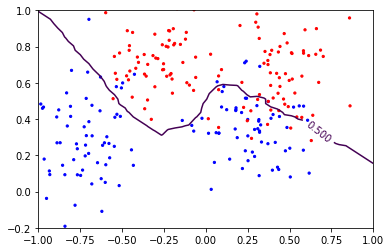

In [43]:
plt.figure()
plt.xlim((-1, 1))
plt.ylim((-0.2, 1))
plt.scatter(xTrain[:,0], xTrain[:,1], c=yTrain, s=5, cmap="bwr")
CS = plt.contour(X, Y, Z, levels=[0.5])
plt.clabel(CS, inline=1, fontsize=10)